In [54]:
# --- CELL 1: IMPORT THƯ VIỆN CHO RANDOM FOREST VÀ CÁC TÁC VỤ LIÊN QUAN ---

# Thư viện cơ bản cho xử lý dữ liệu và tính toán
import pandas as pd
import numpy as np

# Thư viện cho trực quan hóa
import matplotlib.pyplot as plt
import seaborn as sns # Hữu ích cho một số biểu đồ EDA và phân tích phần dư
from sklearn.linear_model import LinearRegression
# Thư viện Scikit-learn
from sklearn.ensemble import RandomForestRegressor # Mô hình Random Forest
from sklearn.model_selection import train_test_split # Dùng để chia train/test (cần cẩn thận với chuỗi thời gian)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Các độ đo đánh giá
import statsmodels.api as sm
# (Tùy chọn) Statsmodels cho phân tích phần dư nâng cao (nếu cần)
# import statsmodels.api as sm # Cho Q-Q plot
# from statsmodels.graphics.tsaplots import plot_acf # Cho ACF của phần dư

# Cài đặt cho Matplotlib để hiển thị biểu đồ ngay trong notebook
%matplotlib inline

# Cài đặt cho Pandas để hiển thị số float (tùy chọn)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_columns', 50)

print("--- Cell 1: Import Thư viện cho Random Forest Hoàn Tất ---")

--- Cell 1: Import Thư viện cho Random Forest Hoàn Tất ---


In [55]:
# --- PHẦN 1: ĐỌC VÀ TIỀN XỬ LÝ DỮ LIỆU CHUNG ---

print("--- BẮT ĐẦU QUÁ TRÌNH XỬ LÝ DỮ LIỆU ---")

# 1.1. Đọc dữ liệu từ file CSV
file_path = 'World GDP Dataset.csv'
try:
    df_raw_initial = pd.read_csv(file_path)
    df_raw = pd.read_csv(file_path, na_values=['0', 0.0])
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy file '{file_path}'. Vui lòng kiểm tra lại đường dẫn.")
    raise
except Exception as e:
    print(f"Lỗi khi đọc file CSV: {e}")
    raise
print("Đọc dữ liệu thô thành công.")

print("\n--- THỐNG KÊ DỮ LIỆU THÔ BAN ĐẦU (df_raw_initial - TRƯỚC KHI XỬ LÝ SÂU) ---")
rows_raw_initial, cols_raw_initial = df_raw_initial.shape
elements_raw_initial = df_raw_initial.size
print(f"Kích thước: {rows_raw_initial} hàng × {cols_raw_initial} cột ({elements_raw_initial} phần tử)")
print("Hiển thị tóm tắt dữ liệu thô ban đầu:")
# Pandas sẽ tự động tóm tắt nếu số hàng > pd.options.display.max_rows (thường là 60)
# Nếu muốn luôn thấy kiểu tóm tắt ngay cả với df nhỏ hơn, bạn cần thủ thuật hơn
# hoặc chấp nhận hiển thị toàn bộ nếu nó nhỏ.
# Với df_raw_initial có 230 hàng, nó sẽ tự tóm tắt.
if 'df_raw_initial' in locals():
    with pd.option_context('display.show_dimensions', True): # Hiển thị kích thước ở cuối
        display(df_raw_initial)
else:
    print("df_raw_initial chưa được tạo.")


# 1.2. Làm sạch cơ bản (áp dụng cho df_raw)
df_raw.dropna(how='all', inplace=True)
rows_before_copyright_removal = len(df_raw)
df_raw = df_raw[~df_raw.iloc[:, 0].astype(str).str.contains("©IMF", na=False)]
rows_after_copyright_removal = len(df_raw)
print(f"\nLàm sạch cơ bản: Loại bỏ {rows_before_copyright_removal - rows_after_copyright_removal} dòng copyright/footer.")

country_col_original_name = df_raw.columns[0]
df_raw.rename(columns={country_col_original_name: 'Country Name'}, inplace=True)
print("Đổi tên cột quốc gia hoàn tất.")

print("\n--- THỐNG KÊ DỮ LIỆU SAU LÀM SẠCH CƠ BẢN (df_raw - TRƯỚC KHI MELT) ---")
rows_raw_cleaned, cols_raw_cleaned = df_raw.shape
elements_raw_cleaned = df_raw.size
print(f"Kích thước: {rows_raw_cleaned} hàng × {cols_raw_cleaned} cột ({elements_raw_cleaned} phần tử)")
print("Hiển thị tóm tắt dữ liệu sau làm sạch cơ bản:")
if 'df_raw' in locals():
    with pd.option_context('display.show_dimensions', True):
        display(df_raw) # df_raw có 196 hàng, cũng sẽ tự tóm tắt
else:
    print("df_raw (đã làm sạch) chưa được tạo.")


# 1.3. Chuyển từ định dạng wide sang long
try:
    df_long = pd.melt(df_raw,
                      id_vars=['Country Name'],
                      var_name='Year',
                      value_name='GDP')
except KeyError as e:
    print(f"Lỗi khi chuyển đổi wide sang long: Cột 'Country Name' hoặc các cột năm không đúng. {e}")
    raise
print("\nChuyển đổi dữ liệu từ wide sang long thành công.")
print("--- THỐNG KÊ DỮ LIỆU SAU KHI MELT (df_long - TRƯỚC KHI CHUYỂN KIỂU VÀ DROPNA) ---")
rows_after_melt, cols_after_melt = df_long.shape
elements_after_melt = df_long.size
print(f"Kích thước: {rows_after_melt} hàng × {cols_after_melt} cột ({elements_after_melt} phần tử)")
print("Hiển thị tóm tắt dữ liệu sau khi melt:")
if 'df_long' in locals():
    with pd.option_context('display.show_dimensions', True):
        # df_long có 8624 hàng, chắc chắn sẽ được Pandas tóm tắt
        display(df_long)
else:
    print("df_long (sau melt) chưa được tạo.")


# 1.4. Chuyển đổi kiểu dữ liệu
df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')
if df_long['GDP'].dtype == 'object':
    df_long['GDP'] = df_long['GDP'].astype(str).str.replace(',', '', regex=False)
df_long['GDP'] = pd.to_numeric(df_long['GDP'], errors='coerce')
print("\nChuyển đổi kiểu dữ liệu cho 'Year' và 'GDP' hoàn tất.")

# 1.5. Xử lý giá trị thiếu (NaN)
rows_before_final_dropna = len(df_long)
df_long.dropna(subset=['Year', 'GDP'], inplace=True)
rows_after_final_dropna = len(df_long)
print(f"Xử lý giá trị thiếu cuối cùng: Số dòng trước khi loại bỏ NaN ở 'Year'/'GDP' (sau chuyển kiểu): {rows_before_final_dropna}")
print(f"Số dòng sau khi loại bỏ NaN cuối cùng: {rows_after_final_dropna}")
print(f"Số dòng đã bị loại bỏ do NaN ở 'Year'/'GDP' hoặc do '0' ban đầu: {rows_before_final_dropna - rows_after_final_dropna}")


# 1.6. Sắp xếp dữ liệu
df_long.sort_values(by=['Country Name', 'Year'], inplace=True)
df_long.reset_index(drop=True, inplace=True)
print("\nSắp xếp dữ liệu theo Quốc gia và Năm hoàn tất.")

print("\n\n--- TIỀN XỬ LÝ DỮ LIỆU HOÀN TẤT (df_long CUỐI CÙNG) ---")
print("--- THỐNG KÊ CHI TIẾT VỀ df_long SAU TẤT CẢ CÁC BƯỚC XỬ LÝ ---")

num_rows_final, num_cols_final = df_long.shape
elements_final = df_long.size
print(f"Kích thước: {num_rows_final} hàng × {num_cols_final} cột ({elements_final} phần tử)")
print("Hiển thị tóm tắt df_long cuối cùng:")
if 'df_long' in locals():
    with pd.option_context('display.show_dimensions', True):
        # df_long có 7852 hàng, chắc chắn sẽ được Pandas tóm tắt
        display(df_long)
else:
    print("df_long (cuối cùng) chưa được tạo.")

# Các thống kê khác giữ nguyên
print(f"\nTên các cột cuối cùng: {df_long.columns.tolist()}")
print("\nKiểu dữ liệu của các cột cuối cùng:")
print(df_long.dtypes)
print("\nSố lượng giá trị duy nhất cho mỗi cột cuối cùng:")
for col in df_long.columns:
    print(f"  - {col}: {df_long[col].nunique()}")
print("\nKiểm tra giá trị thiếu (NaN) trong df_long cuối cùng:")
print(df_long.isnull().sum())
print("\nThống kê mô tả cho các cột số cuối cùng:")
if 'df_long' in locals(): display(df_long.describe())
min_year = df_long['Year'].min() if 'df_long' in locals() and not df_long.empty else 'N/A'
max_year = df_long['Year'].max() if 'df_long' in locals() and not df_long.empty else 'N/A'
print(f"\nPhạm vi năm trong dữ liệu cuối cùng: Từ {min_year} đến {max_year}")
num_unique_countries = df_long['Country Name'].nunique() if 'df_long' in locals() and not df_long.empty else 'N/A'
print(f"Tổng số quốc gia có dữ liệu cuối cùng: {num_unique_countries}")

--- BẮT ĐẦU QUÁ TRÌNH XỬ LÝ DỮ LIỆU ---
Đọc dữ liệu thô thành công.

--- THỐNG KÊ DỮ LIỆU THÔ BAN ĐẦU (df_raw_initial - TRƯỚC KHI XỬ LÝ SÂU) ---
Kích thước: 230 hàng × 45 cột (10350 phần tử)
Hiển thị tóm tắt dữ liệu thô ban đầu:


,"GDP, current prices (Billions of U.S. dollars)",1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,20.616,20.057,18.020,18.883,18.401,18.876,20.136,0.000,0.000,0.000
1,Albania,1.946,2.229,2.296,2.319,2.290,2.339,2.587,2.566,2.530,...,13.246,11.389,11.862,13.053,15.157,15.399,15.161,18.310,18.256,18.842
2,Algeria,42.346,44.372,44.780,47.529,51.513,61.132,61.535,63.300,51.664,...,213.810,165.979,160.034,170.207,175.372,171.680,144.922,162.711,187.155,190.254
3,Andorra,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,3.267,2.789,2.895,2.993,3.217,3.155,2.885,3.330,3.302,3.360
4,Angola,6.639,6.214,6.214,6.476,6.864,8.457,7.918,9.050,9.818,...,145.712,116.194,101.124,122.022,101.353,84.516,58.125,75.179,124.794,135.558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Làm sạch cơ bản: Loại bỏ 1 dòng copyright/footer.
Đổi tên cột quốc gia hoàn tất.

--- THỐNG KÊ DỮ LIỆU SAU LÀM SẠCH CƠ BẢN (df_raw - TRƯỚC KHI MELT) ---
Kích thước: 196 hàng × 45 cột (8820 phần tử)
Hiển thị tóm tắt dữ liệu sau làm sạch cơ bản:


,Country Name,1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.616,20.057,18.020,18.883,18.401,18.876,20.136,NaN,NaN,NaN
1,Albania,1.946,2.229,2.296,2.319,2.290,2.339,2.587,2.566,2.530,...,13.246,11.389,11.862,13.053,15.157,15.399,15.161,18.310,18.256,18.842
2,Algeria,42.346,44.372,44.780,47.529,51.513,61.132,61.535,63.300,51.664,...,213.810,165.979,160.034,170.207,175.372,171.680,144.922,162.711,187.155,190.254
3,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.267,2.789,2.895,2.993,3.217,3.155,2.885,3.330,3.302,3.360
4,Angola,6.639,6.214,6.214,6.476,6.864,8.457,7.918,9.050,9.818,...,145.712,116.194,101.124,122.022,101.353,84.516,58.125,75.179,124.794,135.558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,Vietnam,35.357,17.617,23.369,35.204,61.171,19.045,43.009,53.385,29.501,...,232.888,236.795,252.146,277.071,303.091,327.873,342.941,366.201,413.808,469.620
192,West Bank and Gaza,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.990,13.972,15.405,16.128,16.277,17.134,15.532,18.037,18.818,19.398
193,Yemen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43.229,42.444,31.318,26.842,21.606,21.888,18.850,19.911,27.594,28.099
194,Zambia,4.246,4.385,4.232,3.653,3.003,2.848,1.962,2.431,4.095,...,27.145,21.245,20.965,25.874,26.312,23.309,18.111,21.313,27.025,28.798



Chuyển đổi dữ liệu từ wide sang long thành công.
--- THỐNG KÊ DỮ LIỆU SAU KHI MELT (df_long - TRƯỚC KHI CHUYỂN KIỂU VÀ DROPNA) ---
Kích thước: 8624 hàng × 3 cột (25872 phần tử)
Hiển thị tóm tắt dữ liệu sau khi melt:


,Country Name,Year,GDP
0,Afghanistan,1980,NaN
1,Albania,1980,1.946
2,Algeria,1980,42.346
3,Andorra,1980,NaN
4,Angola,1980,6.639
...,...,...,...
8619,Vietnam,2023,469.620
8620,West Bank and Gaza,2023,19.398
8621,Yemen,2023,28.099
8622,Zambia,2023,28.798



Chuyển đổi kiểu dữ liệu cho 'Year' và 'GDP' hoàn tất.
Xử lý giá trị thiếu cuối cùng: Số dòng trước khi loại bỏ NaN ở 'Year'/'GDP' (sau chuyển kiểu): 8624
Số dòng sau khi loại bỏ NaN cuối cùng: 7852
Số dòng đã bị loại bỏ do NaN ở 'Year'/'GDP' hoặc do '0' ban đầu: 772

Sắp xếp dữ liệu theo Quốc gia và Năm hoàn tất.


--- TIỀN XỬ LÝ DỮ LIỆU HOÀN TẤT (df_long CUỐI CÙNG) ---
--- THỐNG KÊ CHI TIẾT VỀ df_long SAU TẤT CẢ CÁC BƯỚC XỬ LÝ ---
Kích thước: 7852 hàng × 3 cột (23556 phần tử)
Hiển thị tóm tắt df_long cuối cùng:


,Country Name,Year,GDP
0,Afghanistan,2002,4.367
1,Afghanistan,2003,4.553
2,Afghanistan,2004,5.146
3,Afghanistan,2005,6.167
4,Afghanistan,2006,6.925
...,...,...,...
7847,Zimbabwe,2019,22.995
7848,Zimbabwe,2020,23.181
7849,Zimbabwe,2021,32.868
7850,Zimbabwe,2022,38.280



Tên các cột cuối cùng: ['Country Name', 'Year', 'GDP']

Kiểu dữ liệu của các cột cuối cùng:
Country Name     object
Year              int64
GDP             float64
dtype: object

Số lượng giá trị duy nhất cho mỗi cột cuối cùng:
  - Country Name: 196
  - Year: 44
  - GDP: 7052

Kiểm tra giá trị thiếu (NaN) trong df_long cuối cùng:
Country Name    0
Year            0
GDP             0
dtype: int64

Thống kê mô tả cho các cột số cuối cùng:


,Year,GDP
count,7852.000,7852.000
mean,2002.742,263.121
std,12.397,1245.565
min,1980.000,0.014
25%,1993.000,3.260
50%,2003.000,15.974
75%,2013.000,99.016
max,2023.000,26185.210



Phạm vi năm trong dữ liệu cuối cùng: Từ 1980 đến 2023
Tổng số quốc gia có dữ liệu cuối cùng: 196




--- BẮT ĐẦU M_RF_Detrend CHO VIETNAM ---
Đã lọc dữ liệu cho Vietnam. Số dòng ban đầu: 44


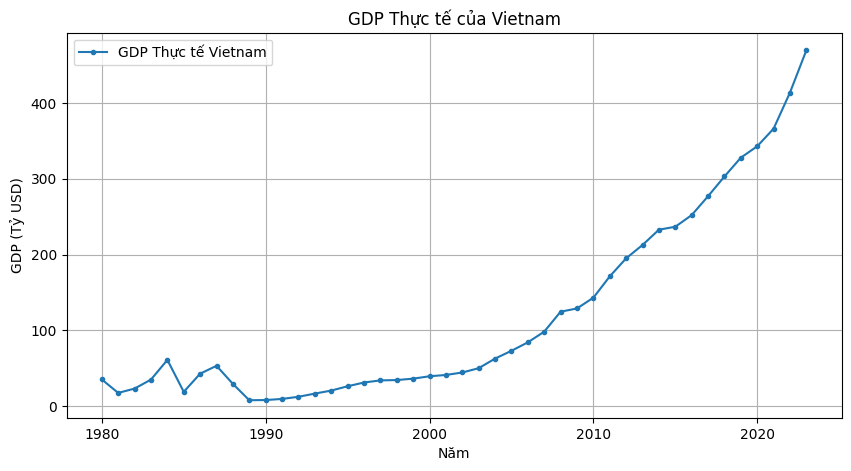

In [56]:
# === THAM SỐ CHUNG CHO MÔ HÌNH NÀY ===
MODEL_ID_RF_DETREND = "M_RF_Detrend" # ID cho mô hình này
COUNTRY_RF_DETREND = 'Vietnam' # <<--- THAY ĐỔI QUỐC GIA Ở ĐÂY
TEST_SIZE_RATIO_RF_DETREND = 0.2
N_FUTURE_YEARS_RF_DETREND = 5
NUM_LAGS_FOR_DETRENDED_RF = 3 # Số lags sử dụng cho RF trên dữ liệu đã loại bỏ xu hướng

# Siêu tham số cho Random Forest (giữ đơn giản)
RF_N_ESTIMATORS = 50
RF_MAX_DEPTH = 3
RF_MIN_SAMPLES_SPLIT = 5
RF_MIN_SAMPLES_LEAF = 2
# ==========================================

print(f"\n\n--- BẮT ĐẦU {MODEL_ID_RF_DETREND} CHO {COUNTRY_RF_DETREND.upper()} ---")

# 1. Lọc dữ liệu cho quốc gia được chọn
if 'df_long' not in locals() or df_long.empty:
    print(f"Lỗi: df_long chưa được tạo hoặc rỗng. Vui lòng chạy Cell 2 trước.")
    country_data_rf_detrend = None
else:
    country_data_rf_detrend = df_long[df_long['Country Name'] == COUNTRY_RF_DETREND].copy()
    country_data_rf_detrend.sort_values('Year', inplace=True)
    country_data_rf_detrend.reset_index(drop=True, inplace=True)

    if country_data_rf_detrend.empty or len(country_data_rf_detrend) < NUM_LAGS_FOR_DETRENDED_RF + 10: # Cần đủ dữ liệu
        print(f"Không đủ dữ liệu cho '{COUNTRY_RF_DETREND}' ({len(country_data_rf_detrend)} điểm) để xây dựng {MODEL_ID_RF_DETREND}.")
        country_data_rf_detrend = None
    else:
        print(f"Đã lọc dữ liệu cho {COUNTRY_RF_DETREND}. Số dòng ban đầu: {len(country_data_rf_detrend)}")
        
        plt.figure(figsize=(10, 5))
        plt.plot(country_data_rf_detrend['Year'], country_data_rf_detrend['GDP'], marker='.', linestyle='-', label=f'GDP Thực tế {COUNTRY_RF_DETREND}')
        plt.title(f'GDP Thực tế của {COUNTRY_RF_DETREND}'); plt.xlabel('Năm'); plt.ylabel('GDP (Tỷ USD)'); plt.grid(True); plt.legend(); plt.show()


Đã ước lượng và loại bỏ xu hướng. Phần GDP đã loại bỏ xu hướng (GDP_Detrended):


,Year,GDP,GDP_Trend,GDP_Detrended
0,1980,35.357,62.319,-26.962
1,1981,17.617,53.228,-35.611
2,1982,23.369,44.977,-21.608


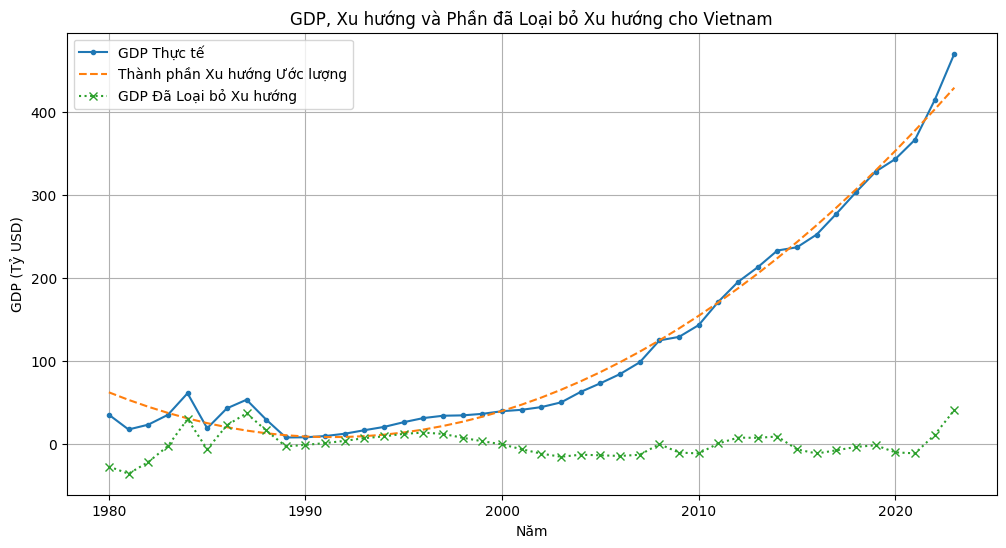


Đã tạo 3 lags cho GDP_Detrended: ['GDP_Detrended_lag1', 'GDP_Detrended_lag2', 'GDP_Detrended_lag3']

Số dòng dữ liệu sau khi tạo lags cho GDP_Detrended và dropna: 41

--- Đặc trưng X cho RF (dựa trên GDP_Detrended lags) ---


,GDP_Detrended_lag1,GDP_Detrended_lag2,GDP_Detrended_lag3
0,-21.608,-35.611,-26.962
1,-2.359,-21.608,-35.611
2,30.182,-2.359,-21.608
3,-6.208,30.182,-2.359
4,22.653,-6.208,30.182



--- Mục tiêu y cho RF (GDP_Detrended) ---


,0,1,2,3,4
GDP_Detrended,-2.359,30.182,-6.208,22.653,37.088


In [57]:
# --- CELL RF_Adv2: {MODEL_ID_RF_DETREND} - ƯỚC LƯỢNG XU HƯỚNG, LOẠI BỎ XU HƯỚNG, TẠO ĐẶC TRƯNG ---

X_rf_detrend, y_rf_detrend_target = None, None # Dữ liệu cho RF
trend_model_rf_detrend = None # Mô hình xu hướng
country_data_processed_rf_detrend = None # Dữ liệu đã thêm cột detrended và lags
feature_columns_rf_detrend = None # Tên các cột lag cho RF

if 'country_data_rf_detrend' in locals() and country_data_rf_detrend is not None:
    # 1. Tạo đặc trưng xu hướng mạnh mẽ
    country_data_rf_detrend['Time_Index'] = np.arange(len(country_data_rf_detrend)) # 0, 1, 2,...
    country_data_rf_detrend['Year_Sq_Feat'] = country_data_rf_detrend['Year'] ** 2
    
    X_trend_features = country_data_rf_detrend[['Year', 'Year_Sq_Feat', 'Time_Index']]
    y_gdp_original = country_data_rf_detrend['GDP']

    # 2. Ước lượng xu hướng bằng Hồi quy Tuyến tính
    trend_model_rf_detrend = LinearRegression()
    trend_model_rf_detrend.fit(X_trend_features, y_gdp_original)
    
    gdp_trend_component = trend_model_rf_detrend.predict(X_trend_features)
    country_data_rf_detrend['GDP_Trend'] = gdp_trend_component
    
    # 3. Loại bỏ xu hướng: Tính phần dư (detrended GDP)
    country_data_rf_detrend['GDP_Detrended'] = y_gdp_original - gdp_trend_component
    
    print("\nĐã ước lượng và loại bỏ xu hướng. Phần GDP đã loại bỏ xu hướng (GDP_Detrended):")
    display(country_data_rf_detrend[['Year', 'GDP', 'GDP_Trend', 'GDP_Detrended']].head(3))

    plt.figure(figsize=(12, 6))
    plt.plot(country_data_rf_detrend['Year'], y_gdp_original, label='GDP Thực tế', marker='.')
    plt.plot(country_data_rf_detrend['Year'], gdp_trend_component, label='Thành phần Xu hướng Ước lượng', linestyle='--')
    plt.plot(country_data_rf_detrend['Year'], country_data_rf_detrend['GDP_Detrended'], label='GDP Đã Loại bỏ Xu hướng', linestyle=':', marker='x')
    plt.title(f'GDP, Xu hướng và Phần đã Loại bỏ Xu hướng cho {COUNTRY_RF_DETREND}')
    plt.xlabel('Năm'); plt.ylabel('GDP (Tỷ USD)'); plt.legend(); plt.grid(True); plt.show()

    # 4. Tạo đặc trưng lags cho Random Forest từ chuỗi GDP_Detrended
    feature_columns_rf_detrend = []
    for i in range(1, NUM_LAGS_FOR_DETRENDED_RF + 1):
        col_name = f'GDP_Detrended_lag{i}'
        country_data_rf_detrend[col_name] = country_data_rf_detrend['GDP_Detrended'].shift(i)
        feature_columns_rf_detrend.append(col_name)
    
    print(f"\nĐã tạo {NUM_LAGS_FOR_DETRENDED_RF} lags cho GDP_Detrended: {feature_columns_rf_detrend}")

    # 5. Xử lý NaN và chuẩn bị X, y cho Random Forest
    country_data_processed_rf_detrend = country_data_rf_detrend.dropna().copy() # Drop NaN do lags
    country_data_processed_rf_detrend.reset_index(drop=True, inplace=True)

    if len(country_data_processed_rf_detrend) < NUM_LAGS_FOR_DETRENDED_RF + 5:
        print(f"Không đủ dữ liệu sau khi tạo lags cho GDP_Detrended ({len(country_data_processed_rf_detrend)} dòng).")
    else:
        print(f"\nSố dòng dữ liệu sau khi tạo lags cho GDP_Detrended và dropna: {len(country_data_processed_rf_detrend)}")
        
        y_rf_detrend_target = country_data_processed_rf_detrend['GDP_Detrended'] # Mục tiêu của RF là phần đã loại bỏ xu hướng
        X_rf_detrend = country_data_processed_rf_detrend[feature_columns_rf_detrend]

        print(f"\n--- Đặc trưng X cho RF (dựa trên GDP_Detrended lags) ---"); display(X_rf_detrend.head())
        print(f"\n--- Mục tiêu y cho RF (GDP_Detrended) ---"); display(y_rf_detrend_target.head().to_frame().T)
else:
    print(f"country_data_rf_detrend chưa được tạo từ cell trước.")

In [58]:
# --- CELL RF_Adv3: {MODEL_ID_RF_DETREND} - CHIA TRAIN/TEST VÀ HUẤN LUYỆN RF ---

model_rf_on_detrended = None
X_train_rf_detrend, X_test_rf_detrend, y_train_rf_detrend_target, y_test_rf_detrend_target = None, None, None, None
years_train_rf_detrend, years_test_rf_detrend = None, None
# Lưu lại các phần của tập test gốc để đánh giá cuối cùng
y_test_gdp_original_rf_detrend = None # GDP gốc của tập test
test_trend_component_rf_detrend = None # Xu hướng của tập test

if 'X_rf_detrend' in locals() and X_rf_detrend is not None and \
   'y_rf_detrend_target' in locals() and y_rf_detrend_target is not None and not X_rf_detrend.empty:

    split_index_rf_detrend = int(len(X_rf_detrend) * (1 - TEST_SIZE_RATIO_RF_DETREND))

    X_train_rf_detrend, X_test_rf_detrend = X_rf_detrend.iloc[:split_index_rf_detrend], X_rf_detrend.iloc[split_index_rf_detrend:]
    y_train_rf_detrend_target, y_test_rf_detrend_target = y_rf_detrend_target.iloc[:split_index_rf_detrend], y_rf_detrend_target.iloc[split_index_rf_detrend:]

    # Lấy năm và GDP gốc, xu hướng gốc tương ứng với tập test
    years_full_processed_rf_detrend = country_data_processed_rf_detrend['Year']
    years_train_rf_detrend = years_full_processed_rf_detrend.iloc[:split_index_rf_detrend]
    years_test_rf_detrend = years_full_processed_rf_detrend.iloc[split_index_rf_detrend:]
    
    y_test_gdp_original_rf_detrend = country_data_processed_rf_detrend['GDP'].iloc[split_index_rf_detrend:]
    test_trend_component_rf_detrend = country_data_processed_rf_detrend['GDP_Trend'].iloc[split_index_rf_detrend:]


    if X_train_rf_detrend.empty or X_test_rf_detrend.empty or len(X_test_rf_detrend) < 1:
        print(f"Không đủ dữ liệu để chia train/test cho {MODEL_ID_RF_DETREND}.")
    else:
        print(f"{MODEL_ID_RF_DETREND} - Chia dữ liệu: Train {len(X_train_rf_detrend)} mẫu, Test {len(X_test_rf_detrend)} mẫu.")

        model_rf_on_detrended = RandomForestRegressor(
            n_estimators=RF_N_ESTIMATORS,
            max_depth=RF_MAX_DEPTH,
            min_samples_split=RF_MIN_SAMPLES_SPLIT,
            min_samples_leaf=RF_MIN_SAMPLES_LEAF,
            random_state=42,
            n_jobs=-1
        )
        
        print(f"\n--- {MODEL_ID_RF_DETREND}: Bắt đầu huấn luyện Random Forest trên GDP_Detrended ---")
        model_rf_on_detrended.fit(X_train_rf_detrend, y_train_rf_detrend_target)
        print(f"Huấn luyện {MODEL_ID_RF_DETREND} hoàn tất.")
else:
    print(f"Dữ liệu X_rf_detrend và y_rf_detrend_target cho {MODEL_ID_RF_DETREND} chưa được tạo.")

M_RF_Detrend - Chia dữ liệu: Train 32 mẫu, Test 9 mẫu.

--- M_RF_Detrend: Bắt đầu huấn luyện Random Forest trên GDP_Detrended ---
Huấn luyện M_RF_Detrend hoàn tất.



--- M_RF_Detrend: Đánh giá trên tập Kiểm tra (GDP gốc) ---
R-squared (Test): 0.9639
MAE (Test): 10.78
RMSE (Test): 13.61
MAPE (Test): 3.11% (Tính trên 9 điểm)


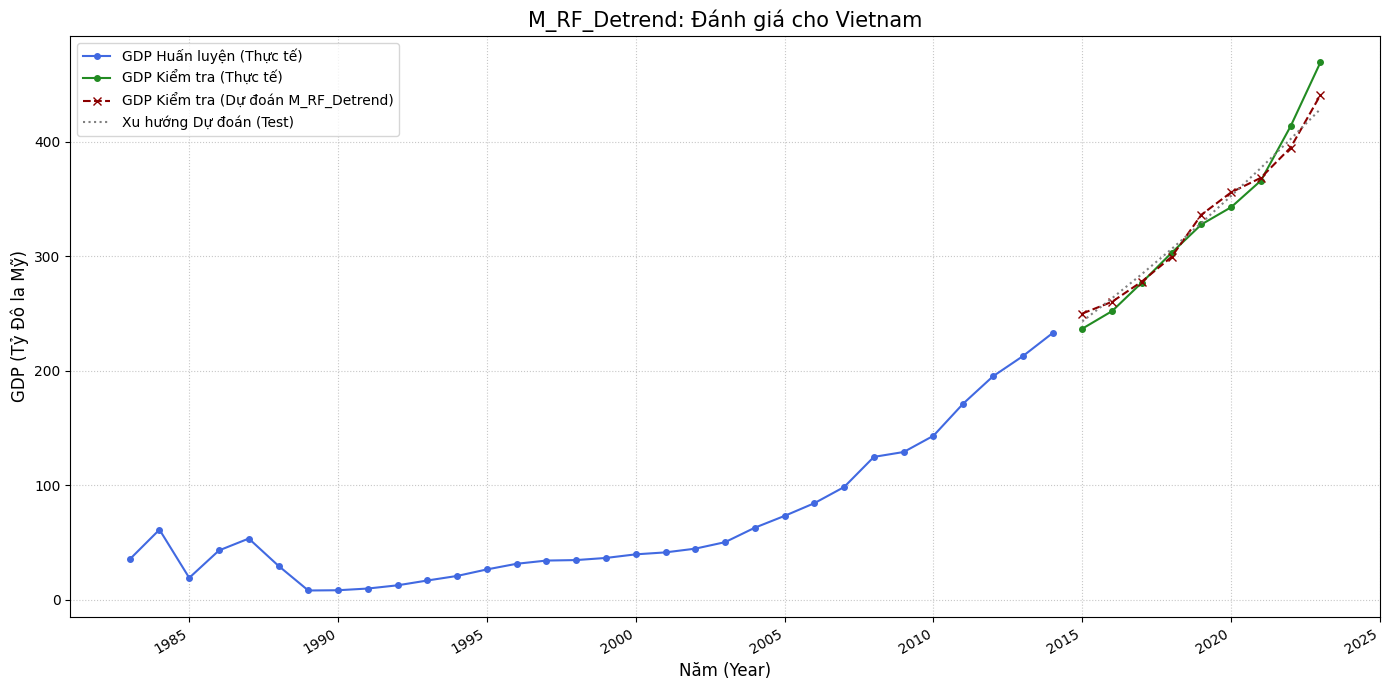

In [59]:
# --- CELL RF_Adv4: {MODEL_ID_RF_DETREND} - ĐÁNH GIÁ MÔ HÌNH (KẾT HỢP XU HƯỚNG) ---

r2_rf_detrend, mae_rf_detrend, rmse_rf_detrend, mape_rf_detrend = np.nan, np.nan, np.nan, np.nan
y_pred_test_final_rf_detrend = None

if 'model_rf_on_detrended' in locals() and model_rf_on_detrended is not None and \
   'X_test_rf_detrend' in locals() and X_test_rf_detrend is not None and not X_test_rf_detrend.empty and \
   'test_trend_component_rf_detrend' in locals() and test_trend_component_rf_detrend is not None and \
   'y_test_gdp_original_rf_detrend' in locals() and y_test_gdp_original_rf_detrend is not None:
    
    # 1. Dự đoán phần đã loại bỏ xu hướng trên tập test
    y_pred_test_detrended_rf = model_rf_on_detrended.predict(X_test_rf_detrend)
    
    # 2. Cộng lại thành phần xu hướng để có dự báo GDP cuối cùng
    y_pred_test_final_rf_detrend = y_pred_test_detrended_rf + test_trend_component_rf_detrend.values # Đảm bảo cộng array với array

    print(f"\n--- {MODEL_ID_RF_DETREND}: Đánh giá trên tập Kiểm tra (GDP gốc) ---")
    r2_rf_detrend = r2_score(y_test_gdp_original_rf_detrend, y_pred_test_final_rf_detrend)
    mae_rf_detrend = mean_absolute_error(y_test_gdp_original_rf_detrend, y_pred_test_final_rf_detrend)
    rmse_rf_detrend = np.sqrt(mean_squared_error(y_test_gdp_original_rf_detrend, y_pred_test_final_rf_detrend))
    
    y_true_m = y_test_gdp_original_rf_detrend.copy(); y_pred_m = pd.Series(y_pred_test_final_rf_detrend, index=y_true_m.index)
    zero_mask = (np.abs(y_true_m) < 1e-9)
    y_true_f = y_true_m[~zero_mask]; y_pred_f = y_pred_m[~zero_mask]
    if len(y_true_f) > 0: mape_rf_detrend = np.mean(np.abs((y_true_f - y_pred_f) / y_true_f)) * 100
    else: mape_rf_detrend = np.nan
            
    print(f"R-squared (Test): {r2_rf_detrend:.4f}")
    print(f"MAE (Test): {mae_rf_detrend:.2f}")
    print(f"RMSE (Test): {rmse_rf_detrend:.2f}")
    if not np.isnan(mape_rf_detrend): print(f"MAPE (Test): {mape_rf_detrend:.2f}% (Tính trên {len(y_true_f)} điểm)")
    else: print("MAPE (Test): Không thể tính.")

    # Trực quan hóa
    plt.figure(figsize=(14, 7))
    if 'years_train_rf_detrend' in locals() and years_train_rf_detrend is not None and 'y_train_rf_detrend_target' in locals() and 'country_data_processed_rf_detrend' in locals():
        # Lấy GDP gốc của tập train để vẽ
        y_train_gdp_original_rf_detrend = country_data_processed_rf_detrend['GDP'].iloc[:len(years_train_rf_detrend)]
        plt.plot(years_train_rf_detrend, y_train_gdp_original_rf_detrend, label='GDP Huấn luyện (Thực tế)', color='royalblue', marker='o', markersize=4)
    
    plt.plot(years_test_rf_detrend, y_test_gdp_original_rf_detrend, label='GDP Kiểm tra (Thực tế)', color='forestgreen', marker='o', markersize=4)
    plt.plot(years_test_rf_detrend, y_pred_test_final_rf_detrend, label=f'GDP Kiểm tra (Dự đoán {MODEL_ID_RF_DETREND})', color='darkred', marker='x', markersize=6, linestyle='--')
    plt.plot(years_test_rf_detrend, test_trend_component_rf_detrend, label='Xu hướng Dự đoán (Test)', color='gray', linestyle=':') # Vẽ thêm đường xu hướng
    
    plt.title(f'{MODEL_ID_RF_DETREND}: Đánh giá cho {COUNTRY_RF_DETREND}', fontsize=15)
    plt.xlabel('Năm (Year)', fontsize=12); plt.ylabel('GDP (Tỷ Đô la Mỹ)', fontsize=12)
    plt.legend(fontsize=10); plt.grid(True, linestyle=':', alpha=0.7); plt.xticks(rotation=30, ha='right'); plt.tight_layout(); plt.show()
else:
    print(f"Mô hình {MODEL_ID_RF_DETREND} chưa được huấn luyện hoặc không có đủ dữ liệu test để đánh giá.")



--- M_RF_Detrend: PHÂN TÍCH PHẦN DƯ CHO VIETNAM (TRÊN GDP GỐC) ---


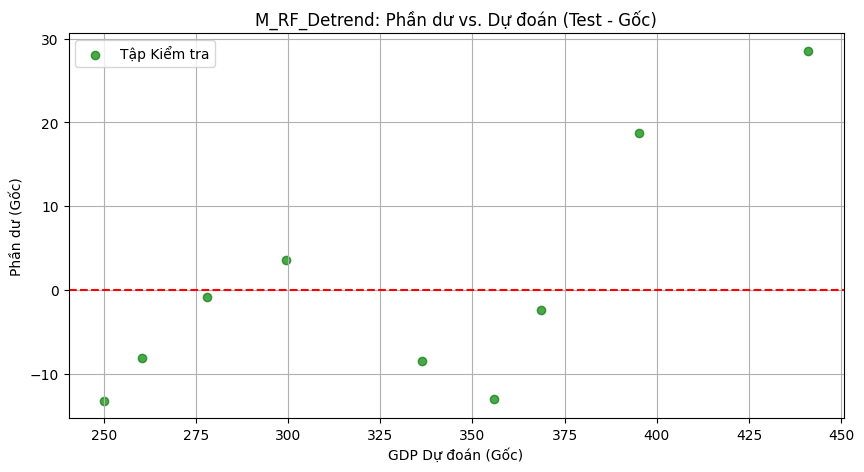

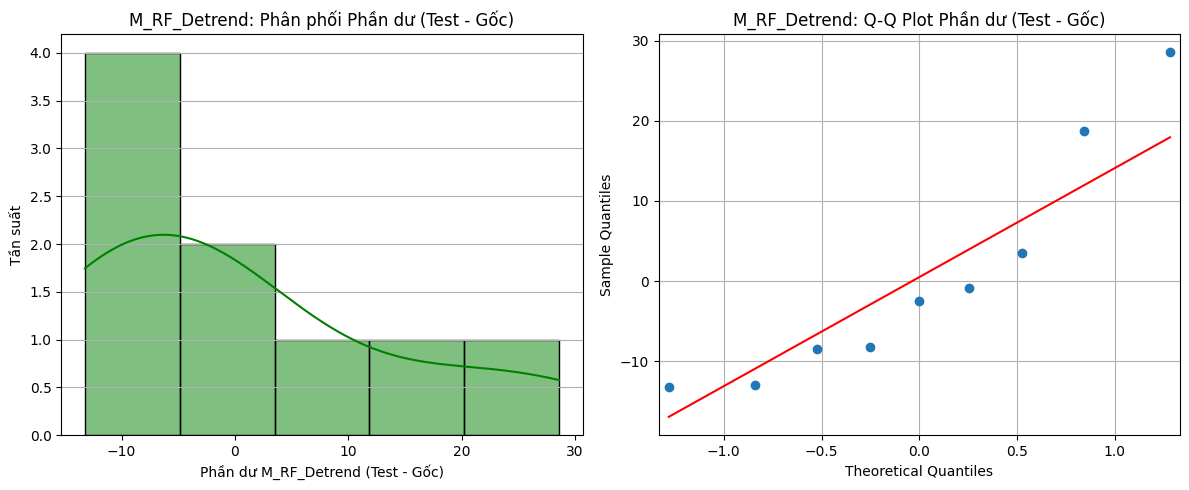

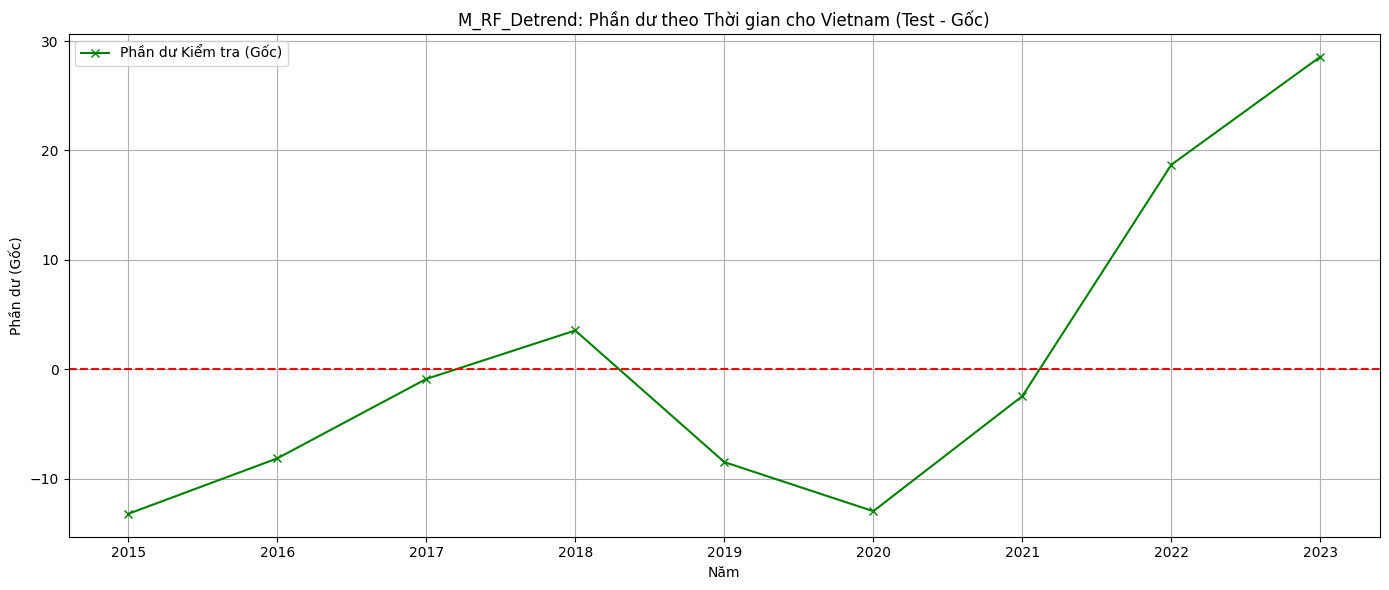

In [60]:
# --- CELL RF_Adv5: {MODEL_ID_RF_DETREND} - PHÂN TÍCH PHẦN DƯ ---

if 'y_test_gdp_original_rf_detrend' in locals() and y_test_gdp_original_rf_detrend is not None and \
   'y_pred_test_final_rf_detrend' in locals() and y_pred_test_final_rf_detrend is not None:
    
    print(f"\n\n--- {MODEL_ID_RF_DETREND}: PHÂN TÍCH PHẦN DƯ CHO {COUNTRY_RF_DETREND.upper()} (TRÊN GDP GỐC) ---")
    
    residuals_final_rf_detrend = y_test_gdp_original_rf_detrend.values - y_pred_test_final_rf_detrend

    # 1. Biểu đồ Phân tán Phần dư (Residuals vs. Predicted Values - thang đo gốc)
    plt.figure(figsize=(10, 5))
    plt.scatter(y_pred_test_final_rf_detrend, residuals_final_rf_detrend, alpha=0.7, label='Tập Kiểm tra', color='green')
    plt.axhline(y=0, color='r', linestyle='--'); plt.xlabel('GDP Dự đoán (Gốc)'); plt.ylabel('Phần dư (Gốc)')
    plt.title(f'{MODEL_ID_RF_DETREND}: Phần dư vs. Dự đoán (Test - Gốc)'); plt.legend(); plt.grid(True); plt.show()

    # 2. Biểu đồ Phân phối của Phần dư
    plt.figure(figsize=(12, 5)); plt.subplot(1, 2, 1)
    sns.histplot(residuals_final_rf_detrend, bins=max(5, len(residuals_final_rf_detrend)//2), kde=True, edgecolor='black', color='green')
    plt.xlabel(f'Phần dư {MODEL_ID_RF_DETREND} (Test - Gốc)'); plt.ylabel('Tần suất'); 
    plt.title(f'{MODEL_ID_RF_DETREND}: Phân phối Phần dư (Test - Gốc)'); plt.grid(axis='y');
    plt.subplot(1, 2, 2); sm.qqplot(residuals_final_rf_detrend, line='s', ax=plt.gca()); 
    plt.title(f'{MODEL_ID_RF_DETREND}: Q-Q Plot Phần dư (Test - Gốc)'); plt.grid(True)
    plt.tight_layout(); plt.show()

    # 3. Biểu đồ Phần dư theo Thời gian
    plt.figure(figsize=(14, 6))
    if 'years_test_rf_detrend' in locals() and years_test_rf_detrend is not None and len(years_test_rf_detrend) == len(residuals_final_rf_detrend):
        plt.plot(years_test_rf_detrend, residuals_final_rf_detrend, marker='x', linestyle='-', color='green', label='Phần dư Kiểm tra (Gốc)')
        plt.axhline(y=0, color='r', linestyle='--'); plt.xlabel('Năm'); plt.ylabel('Phần dư (Gốc)')
        plt.title(f'{MODEL_ID_RF_DETREND}: Phần dư theo Thời gian cho {COUNTRY_RF_DETREND} (Test - Gốc)'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
else:
    print(f"Mô hình {MODEL_ID_RF_DETREND} chưa có đủ kết quả để phân tích phần dư.")